In [2]:
using Images
using Statistics
using Plots
using DSP
using StatsBase

In [1]:
function mask_site(file; n_sites=1)
    img = load(file)
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    # Do frame averaging
    im_array = im_array ./ frame_avg
    # Do mean value subtraction
    im_array = im_array .- mean(im_array)
    # Use stack sum projection to find polarity patch(es)
    avgimg = mean(im_array, dims=(3))[:,:,1]
    max_bin = 0
    threshold = 0.55
    bin = avgimg .> maximum(avgimg)*threshold
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin             # Half max of average is used as threshold
        max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
        max_lab = bin_lab[max_loc]                  
        max_bin = bin_lab .== max_lab               # Make mask only around correct component
        im_masked = im_array .* max_bin
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [11]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    start = Integer(findall(signal .> (maximum(signal))*thresh)[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        print(".")
        last = length(signal)
        times = last-Integer(frames):last
        return times
    end
end

crop_times (generic function with 1 method)

In [8]:
max(5:60, 4:59)

5:60

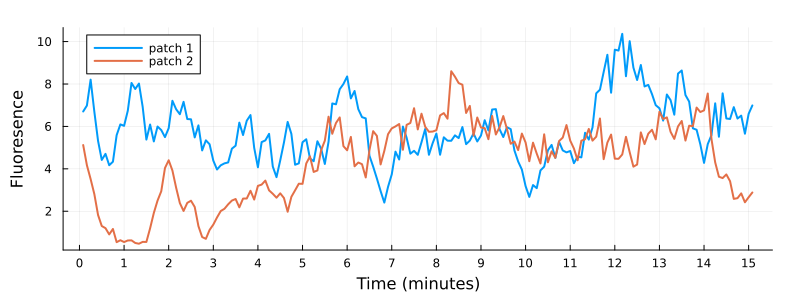

In [28]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell2.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
t = range(1,length(crop1))*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, linewidth=2, label="patch 1", xlabel="Time (minutes)", 
    ylabel="Fluoresence", size=(800,300), margin=5Plots.mm, xticks=0:1:30)
plot!(t, crop2,label="patch 2", linewidth=2, color=2)

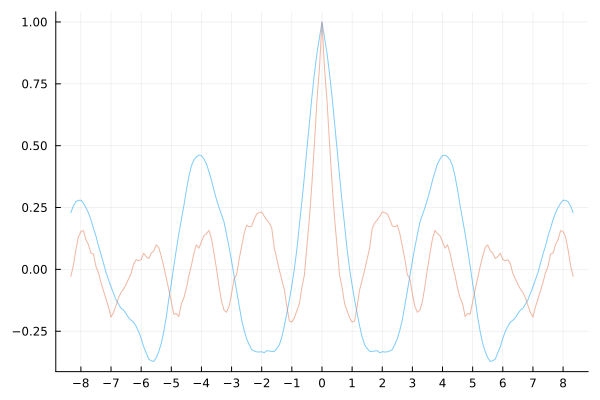

In [36]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell1.tif" # bad. polarizes at very end of movie. 
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie3-cell1.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
ac1 = crosscor(crop1, crop1, -100:100)
ac2 = crosscor(crop2, crop2, -100:100)
all_ac += ac1
all_ac += ac2
n+=2
plot(t_cor, ac1, x_ticks=-8:1:8, alpha=0.5, label=false, color=1)
plot!(t_cor, ac2, x_ticks=-8:1:8, alpha=0.5, label=false, color=2)

.

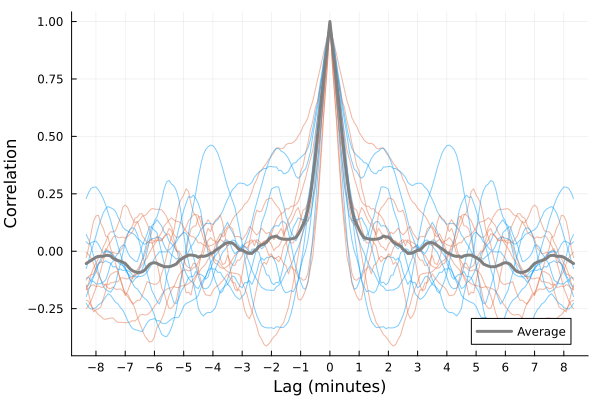

In [41]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_ac = zeros(201)
t_cor = range(-100,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    ac1 = crosscor(crop1, crop1, -100:100)
    ac2 = crosscor(crop2, crop2, -100:100)
    all_ac += ac1
    #all_ac += ac2
    n+=1
    plot!(t_cor, ac1, x_ticks=-8:1:8, alpha=0.5, label=false, color=1)
    plot!(t_cor, ac2, x_ticks=-8:1:8, alpha=0.5, label=false, color=2)
end

plot!(t_cor, all_ac./(n), x_ticks=-8:1:8, linewidth=3, color="grey", alpha=1, label="Average")

.

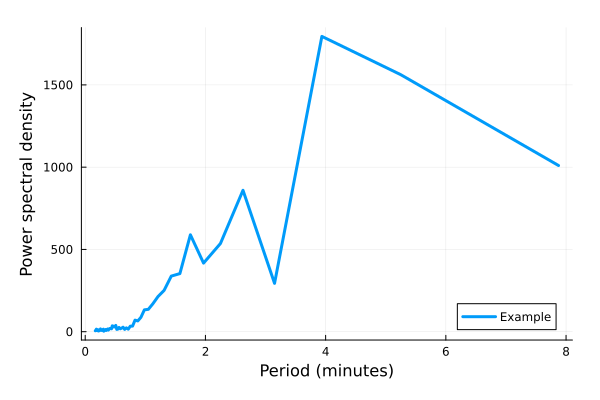

In [49]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
max_powers = zeros(95)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    pdg_max1 = DSP.Periodograms.periodogram(crop1)
    pdg_max2 = DSP.Periodograms.periodogram(crop2)
    max_powers = max_powers .+ pdg_max1.power
    max_powers = max_powers .+ pdg_max2.power
    frequencies = pdg_max1.freq
    global frequencies
    n+=1
end

plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end], xflip = false, label="Example", linewidth=3, alpha=1, margin=5Plots.mm, color=1)


In [71]:
pos_max = findmax(all_cor)[2]*(5/60)

2.833333333333333

.

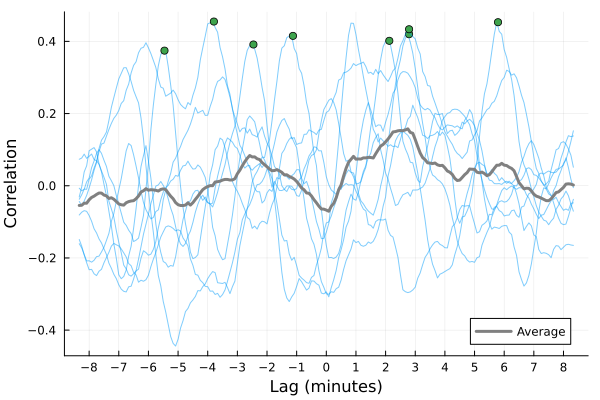

In [80]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(201)
t_cor = range(-100,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor = crosscor(crop1, crop2, -100:100)
    all_cor += cor
    n+=1
    plot!(t_cor, cor, x_ticks=-8:1:8, alpha=0.5, label=false, color=1)
    pos_max = findmax(cor)[2]*(5/60) - (length(cor)/2)*(5/60)
    val_max = maximum(cor)
    scatter!((pos_max, val_max), color=3, label=false)
end

plot!(t_cor, all_cor./(n), x_ticks=-8:1:8, linewidth=3, color="grey", alpha=1, label="Average")

In [55]:
all_cor

101-element Vector{Float64}:
 -0.5395509273942791
 -0.4819327402777217
 -0.2884568492926343
 -0.13978569378159023
  0.06751800740141733
  0.3233035470988219
  0.5191484143413503
  0.7961811477453777
  1.0529676563314105
  1.268984512494716
  ⋮
  7.443531402405329
  7.598933559710009
  7.697073715517668
  7.8303618159311155
  7.963327189489213
  8.119521277754243
  8.20969598375831
  8.286608948330425
  8.348739480395936

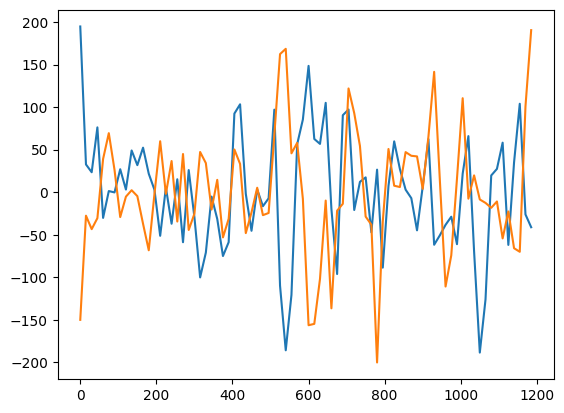

In [102]:
plt.plot(t, highpass01, t, highpass02)

In [103]:
np.corrcoef(highpass01,highpass02)[0,1]

-0.3350724194901477